In [1]:
!pip install torch torchvision
!pip install Pillow==4.0.0

  Using cached https://files.pythonhosted.org/packages/b6/c0/442d9d87e0da00bf856ef6dd4916f84a2d710b5f1a367d42d7f3c4e99a6c/Pillow-8.1.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.8.1+cu101 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 8.1.0
    Uninstalling Pillow-8.1.0:
      Successfully uninstalled Pillow-8.1.0


In [2]:
%matplotlib inline
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [3]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
  param.requires_grad_(False)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [17]:
def load_image(img_path, max_size=400, shape=None):
  image = Image.open(img_path).convert('RGB')
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  if shape is not None:
    size = shape
  
  in_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])
  image = in_transform(image).unsqueeze(0)
  return image

In [73]:
content = load_image('me.JPG').to(device)
style = load_image('abstract4.jpg', shape=content.shape[-2:]).to(device)

In [74]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.squeeze()
  image = image.transpose(1, 2, 0)  
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

(-0.5, 399.5, 405.5, -0.5)

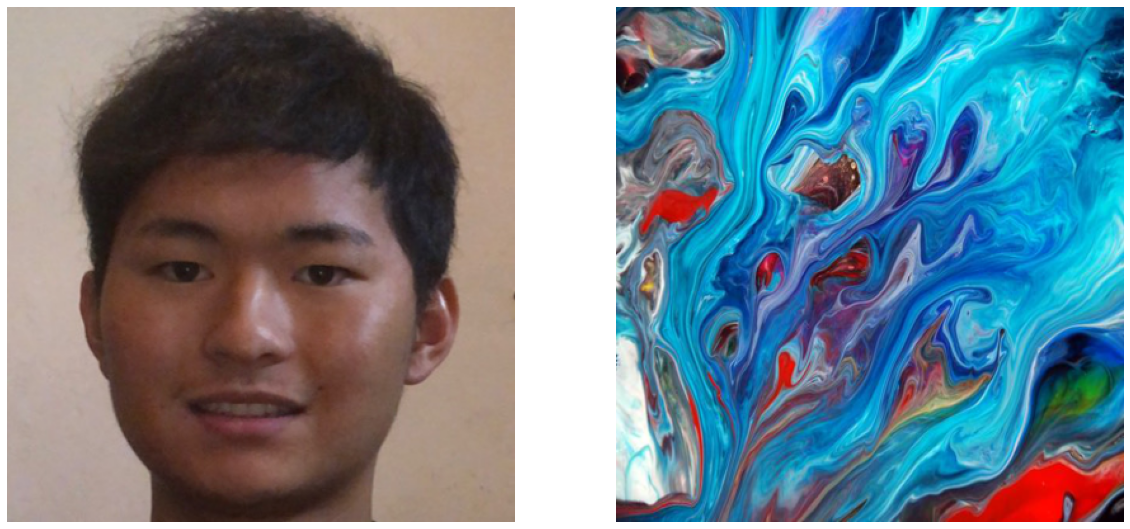

In [75]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')

In [76]:
def get_features(image, model):
  layers = {
      '0': 'conv1_1',
      '5': 'conv2_1',
      '10': 'conv3_1',
      '19': 'conv4_1',
      '28': 'conv5_1',
      '21': 'conv4_2', # => content extraction
  }
  features = {}

  for name, layer in model._modules.items():
    image = layer(image)
    if name in layers:
      features[layers[name]] = image
  return features


In [77]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [78]:
def gram_matrix(tensor):
  _, d, h, w = tensor.size()
  tensor = tensor.view(d, h*w)
  gram = torch.mm(tensor, tensor.t())
  return gram

In [79]:
style_grams = { layer: gram_matrix(style_features[layer]) for layer in style_features}
style_weights = {
    'conv1_1': 1.,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2,
}

content_weight = 1
style_weight = 1e7

In [80]:
target = content.clone().requires_grad_(True).to(device)

Total loss:  352619104.0
Iteration:  300


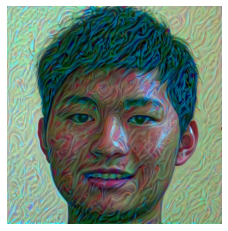

Total loss:  18533996.0
Iteration:  600


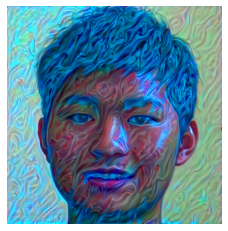

Total loss:  8768835.0
Iteration:  900


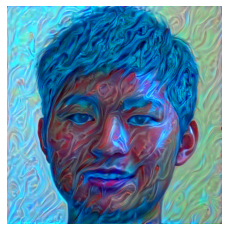

Total loss:  5021768.0
Iteration:  1200


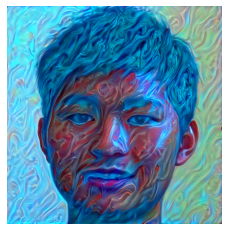

In [ ]:
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 2100
height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps / show_every
counter = 0

for ii in range(1, steps+1):
  target_features = get_features(target, vgg)
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
  style_loss = 0
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    _, d, h, w = target_feature.shape
    style_loss += torch.mean((target_gram - style_gram) ** 2) * style_weights[layer] / (d * h * w)
  total_loss = content_loss * content_weight + style_loss * style_weight

  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if ii % show_every == 0:
    print("Total loss: ", total_loss.item())
    print("Iteration: ", ii)
    plt.imshow(im_convert(target))
    plt.axis('off')
    plt.show()
  
  if ii % capture_frame == 0:
    image_array[counter] = im_convert(target)
    counter+=1
  

